# POS Tagger Trained on the UD Treebank

Adapted from https://github.com/soutsios/pos_tagger_mlp/blob/master/pos_tagger_mlp.ipynb 

# Plot Functions

These functions are useful to visualize the training dynamics of the learning algorithm and the confusion matrix of the trained models.

In [45]:
import pyconll, nltk, datetime, warnings
import numpy as np
from scipy.sparse import vstack
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV, learning_curve
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)
from numpy.random import seed

In [46]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [47]:
def plot_confusion_matrix(f1,
                          cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          i=1):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    plt.figure(figsize=(10, 6))
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}; f1-score={:0.4f}'.format(accuracy, misclass, f1))

# Load Dataset

In [48]:
UD_ENGLISH_TRAIN = '../UD_English-EWT/en_ewt-ud-train.conllu'
UD_ENGLISH_DEV = '../UD_English-EWT/en_ewt-ud-dev.conllu'
UD_ENGLISH_TEST = '../UD_English-EWT/en_ewt-ud-test.conllu'

# Preprocessing

In [49]:
def read_conllu(path):
    data = pyconll.load_from_file(path)
    tagged_sentences=[]
    original_sentences=[]
    t=0
    for sentence in data:
        original_sentences.append(sentence.text)
        tagged_sentence=[]
        for token in sentence:
            if token.upos:
                t+=1
                tagged_sentence.append((token.form if token.form else '*None*', token.upos))
        tagged_sentences.append(tagged_sentence)
    return tagged_sentences, original_sentences

Load train, development and test set in the appropriate tagged format, tuple (word, pos-tag)

In [50]:
train_sentences, train_original = read_conllu(UD_ENGLISH_TRAIN)
val_sentences, val_original = read_conllu(UD_ENGLISH_DEV)
test_sentences, test_original = read_conllu(UD_ENGLISH_TEST)

Print statistics

In [51]:
print("Tagged sentences in train set: ", len(train_sentences))
print("Tagged words in train set:", len([item for sublist in train_sentences for item in sublist]))
print(40*'=')
print("Tagged sentences in dev set: ", len(val_sentences))
print("Tagged words in dev set:", len([item for sublist in val_sentences for item in sublist]))
print(40*'=')
print("Tagged sentences in test set: ", len(test_sentences))
print("Tagged words in test set:", len([item for sublist in test_sentences for item in sublist]))

Tagged sentences in train set:  12544
Tagged words in train set: 204616
Tagged sentences in dev set:  2001
Tagged words in dev set: 25153
Tagged sentences in test set:  2077
Tagged words in test set: 25096


In [52]:
print(train_sentences[0])

[('Al', 'PROPN'), ('-', 'PUNCT'), ('Zaman', 'PROPN'), (':', 'PUNCT'), ('American', 'ADJ'), ('forces', 'NOUN'), ('killed', 'VERB'), ('Shaikh', 'PROPN'), ('Abdullah', 'PROPN'), ('al', 'PROPN'), ('-', 'PUNCT'), ('Ani', 'PROPN'), (',', 'PUNCT'), ('the', 'DET'), ('preacher', 'NOUN'), ('at', 'ADP'), ('the', 'DET'), ('mosque', 'NOUN'), ('in', 'ADP'), ('the', 'DET'), ('town', 'NOUN'), ('of', 'ADP'), ('Qaim', 'PROPN'), (',', 'PUNCT'), ('near', 'ADP'), ('the', 'DET'), ('Syrian', 'ADJ'), ('border', 'NOUN'), ('.', 'PUNCT')]


In [53]:
def tag_sequence(sentences):
    return [[t for w, t in sentence] for sentence in sentences]

def text_sequence(sentences):
    return [[w for w, t in sentence] for sentence in sentences]

def id2word(sentences):
    wordlist = [item for sublist in text_sequence(sentences) for item in sublist]
    id2word = {k:v for k,v in enumerate(wordlist)}
    return id2word

def untag(tagged_sentence):
    return [w for w, _ in tagged_sentence]

def untag_pos(tagged_sentence):
    return [t for _, t in tagged_sentence]

def build_vocab(sentences):
    vocab =set()
    for sentence in sentences:
        for word in untag(sentence):
            vocab.add(word)
    return sorted(list(vocab))

An important observation: how many terms are in validation set and not found in train set? (This estimates the Out-of-vocabulary rate.)

In [54]:
list_1 = build_vocab(train_sentences)
list_2 = build_vocab(val_sentences)
diff_list = [item for item in list_2 if item not in list_1]
print('Number of terms not found in train set:',len(diff_list))

Number of terms not found in train set: 1661


# Feature Engineering

We use the "classical" machine learning approach: we will train a token classifier model. The classifier gets as input a feature vector describing each token in the sentence. We decide a priori which features are informative to make the tagging decision. In this case, we use a combination of "word shape" features which approximate morphological knowledge. We naturally also include lexical information (the token form itself), and some form of "syntactic knowledge" by adding reference to the previous and next word in each token feature vector.

In [55]:
def features_basic(sentence, index):
    """ sentence: [w1, w2, ...], index: the index of the word """
    return {
        'nb_terms': len(sentence),        
        'word': sentence[index],
        'word_lower': sentence[index].lower(),
        'is_first': index == 0,
        'is_last': index == len(sentence) - 1,
        'is_capitalized': sentence[index][0].upper() == sentence[index][0],
        'is_all_caps': sentence[index].upper() == sentence[index],
        'is_all_lower': sentence[index].lower() == sentence[index],
        'prefix-1': sentence[index][0],
        'prefix-2': sentence[index][:2],
        'prefix-3': sentence[index][:3],
        'suffix-1': sentence[index][-1],
        'suffix-2': sentence[index][-2:],
        'suffix-3': sentence[index][-3:],
        'i-1_prefix-3': '' if index == 0 else sentence[index-1][:3],        
        'i-1_suffix-3': '' if index == 0 else sentence[index-1][-3:],        
        'i+1_prefix-3': '' if index == len(sentence) - 1 else sentence[index+1][:3],        
        'i+1_suffix-3': '' if index == len(sentence) - 1 else sentence[index+1][-3:],        
        'prev_word': '' if index == 0 else sentence[index - 1].lower(),
        'next_word': '' if index == len(sentence) - 1 else sentence[index + 1].lower(),
        'has_hyphen': '-' in sentence[index],
        'is_numeric': sentence[index].isdigit(),
        'capitals_inside': sentence[index][1:].lower() != sentence[index][1:],
    }

In the scikit-learn model, we model a dataset as a pair of two data structures:
* The list of feature dictionaries X (one feature dictionary for each token)
* The list of predicted label y (one tag for each token)

In [56]:
def transform_to_dataset(tagged_sentences):
    X, y = [], []
    for doc_index, tagged in enumerate(tagged_sentences):
        for index in range(len(tagged)):
            X.append([features_basic(untag(tagged), index)])
            y.append(tagged[index][1])
    return X, y

Given a sentence represented as a list of tokens, return the list of feature dictionaries using our feature encoding method:

In [57]:
def transform_test_sentence(sentence):
    X = []
    for index in range(len(sentence)):
            X.append([features_basic(sentence, index)])
    return X

## Test untag()

We use untag() to extract raw sentences from the annotated CoNLL dataset. This way we can reproduce a sentence without tags, submit it to the tagger and compare predictions to the gold tags that are provided in the dataset.

In [58]:
untag(test_sentences[1])

['What',
 'if',
 'Google',
 'expanded',
 'on',
 'its',
 'search',
 '-',
 'engine',
 '(',
 'and',
 'now',
 'e-mail',
 ')',
 'wares',
 'into',
 'a',
 'full',
 '-',
 'fledged',
 'operating',
 'system',
 '?']

# Dataset Transformation

Before we can apply a generic machine learning algorithm (such as Logistic Regression), we need to encode the dataset into a vectorized format.

We proceed in two steps: feature engineering and vectorization.

For each token, we create a dictionary of features that depend on the sentence from which the token is extracted. 
These features include the word itself, the word before and the word after, letter suffixes and prefixes, etc.

In the scikit-learn approach, before we can use a generic machine learning algorithm, we must then "vectorize" the feature dictionaries into vector encodings.
For example, lexical features are encoded into one-hot vectors whose dimension is the size of the vocabulary.
Note the difference between the method `fit_transform` of the vectorizer, which "learns" how to vectorize features, and `transform` which applies a learned vectorizer to feature dictionaries.  We use `fit_transform` on the training data, and `transform` on the other sections (validation and test).

These vector representations are what is passed to the machine learning algorithm.

In [59]:
def vectorize(train, val, test):

    print('Feature encoding method')
    print('Vectorizing Dataset...')
    print('Vectorizing train...')
    X_train, y_train = transform_to_dataset(train)
    v = DictVectorizer(sparse=True) 
    X_train = v.fit_transform([x[0] for x in X_train])
    
    print('Vectorizing validation...')
    X_val, y_val = transform_to_dataset(val)
    X_val = v.transform([x[0] for x in X_val])        
    
    print('Vectorizing test...')
    X_test, y_test = transform_to_dataset(test)
    X_test = v.transform([x[0] for x in X_test])
    
    print('Dataset vectorized.')
    print('Train shape:', X_train.shape)
    print('Validation shape:', X_val.shape)
    print('Test shape:', X_test.shape)
    
    # Compress sparse matrices
    X_train = X_train 
    X_val = X_val 
    X_test = X_test
    return X_train, y_train, X_val, y_val, X_test, y_test, v
    

# Baseline Tagger

Before we train a "real" machine learning algorithm using scikit-learn, we will repeat the very simple statistical method we discussed in class.
We train and evaluate the Baseline Unigram tagger to compare performance with the tagger we will train next.

In [60]:
default_tagger = nltk.DefaultTagger('NOUN')
unigram_tagger = nltk.UnigramTagger(train_sentences+val_sentences, backoff=default_tagger)

In [61]:
y_train = [item for sublist in tag_sequence(train_sentences+val_sentences) for item in sublist]
y_test = [item for sublist in tag_sequence(test_sentences) for item in sublist]
classes = sorted(list(set(y_train)))

In [62]:
def tag_list(tagged_sents):
    return [tag for sent in tagged_sents for (word, tag) in sent]
def apply_tagger(tagger, corpus):
    return [tagger.tag(nltk.tag.untag(sent)) for sent in corpus]

In [63]:
y_pred = tag_list(apply_tagger(unigram_tagger, test_sentences))
print("Accuracy: {0:.4f}".format(unigram_tagger.accuracy(test_sentences)))
print('f1-macro score: {0:.4f}'.format(f1_score(y_test, y_pred, zero_division=1, average='macro')))

Accuracy: 0.8671
f1-macro score: 0.7965


In [64]:
print(classification_report(y_test, y_pred, zero_division=1, digits=4))

              precision    recall  f1-score   support

         ADJ     0.9158    0.8367    0.8745      1794
         ADP     0.8697    0.8813    0.8755      2030
         ADV     0.9341    0.8030    0.8636      1183
         AUX     0.9233    0.8970    0.9099      1543
       CCONJ     0.9892    0.9973    0.9932       736
         DET     0.9612    0.9678    0.9645      1896
        INTJ     0.9655    0.6942    0.8077       121
        NOUN     0.6879    0.9331    0.7920      4123
         NUM     0.9146    0.6125    0.7337       542
        PART     0.6959    0.9769    0.8128       649
        PRON     0.9665    0.9321    0.9490      2166
       PROPN     0.9240    0.5443    0.6851      2076
       PUNCT     0.9941    0.9861    0.9901      3096
       SCONJ     0.6257    0.5964    0.6107       384
         SYM     0.8125    0.8349    0.8235       109
        VERB     0.8880    0.8243    0.8549      2606
           X     1.0000    0.0000    0.0000        42

    accuracy              

See what errors the Baseline tagger makes:

In [65]:
def check_tagger(tagged_sentence):
    note = ''
    for tup in list(zip(unigram_tagger.tag(untag(tagged_sentence)),untag_pos(tagged_sentence))):
        if tup[0][1]!=tup[1]: note='<<--- Error!'
        print(tup[0], tup[1], note)
        note=''

In [66]:
check_tagger(test_sentences[1])

('What', 'PRON') PRON 
('if', 'SCONJ') SCONJ 
('Google', 'PROPN') PROPN 
('expanded', 'VERB') VERB 
('on', 'ADP') ADP 
('its', 'PRON') PRON 
('search', 'NOUN') NOUN 
('-', 'PUNCT') PUNCT 
('engine', 'NOUN') NOUN 
('(', 'PUNCT') PUNCT 
('and', 'CCONJ') CCONJ 
('now', 'ADV') ADV 
('e-mail', 'NOUN') NOUN 
(')', 'PUNCT') PUNCT 
('wares', 'NOUN') NOUN 
('into', 'ADP') ADP 
('a', 'DET') DET 
('full', 'ADJ') ADV <<--- Error!
('-', 'PUNCT') PUNCT 
('fledged', 'NOUN') ADJ <<--- Error!
('operating', 'NOUN') NOUN 
('system', 'NOUN') NOUN 
('?', 'PUNCT') PUNCT 


It makes mistakes. Unsurprising given its simplistic approach and the small size of the training data.

In [67]:
cnf_matrix = confusion_matrix(y_test, y_pred)
name='Baseline'

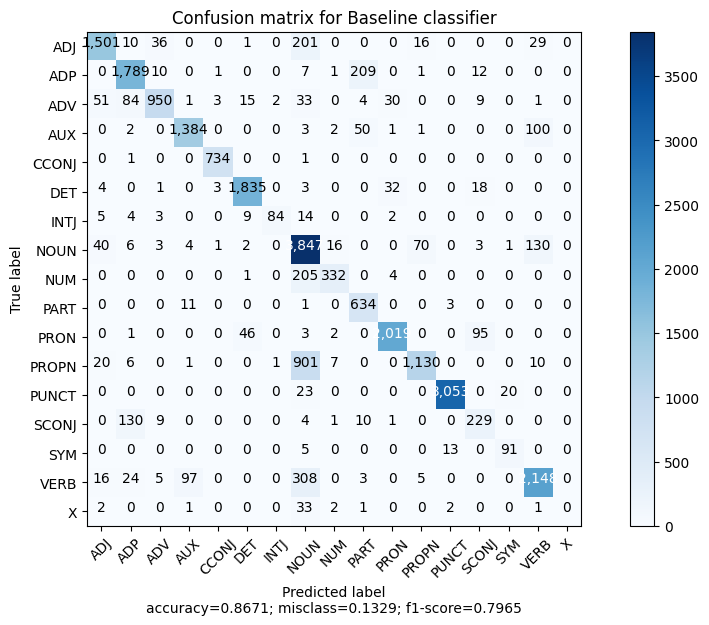

In [68]:
plot_confusion_matrix(f1_score(y_test, y_pred, average='macro'), cnf_matrix, target_names=classes, title='Confusion matrix for '+name+' classifier', normalize=False)

# Train a Logistic Regression Model

Let us move to a more serious machine learning model. We will train a Logistic Regression model using our feature extraction function based on our "expertise" in the domain.

We first transform the whole dataset from the CoNLL format into the scikit-learn vectorized encoding using our feature extraction method.

In [69]:
X_train, y_train, X_val, y_val, X_test, y_test, vec = vectorize(train_sentences, val_sentences, test_sentences)

Feature encoding method
Vectorizing Dataset...
Vectorizing train...
Vectorizing validation...
Vectorizing test...
Dataset vectorized.
Train shape: (204616, 98724)
Validation shape: (25153, 98724)
Test shape: (25096, 98724)


## Hyper-parameter Tuning

The Logistic Regression algorithm uses a hyper-parameter called C.  We tune the value of this parameter by testing different values on a subset of the training data and observing the impact of the C parameter on selected metrics (accuracy and F1).

Because we will use cross-validation, we can use the full train set (train + validation)

In [70]:
X_train = vstack((X_train, X_val))
y_train = np.append(y_train, y_val, axis=0)

In [71]:
X_train.shape

(229769, 98724)

In [72]:
y_train.shape

(229769,)

In [73]:
def hyper_tuning(train, test, y_train, y_test, scores, estimator, parameters, cv):
    print("# Estimator:",estimator)
    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)        
        clf = GridSearchCV(estimator, parameters, cv=cv, scoring='%s' % score)
        clf.fit(train, y_train)
        print("Best parameters set found on development set:")
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        print()
        print("Detailed classification report:")
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        y_pred = clf.predict(test)
        print(classification_report(y_test, y_pred, digits=4))
        print('Accuracy: {0:0.4f}   f1-score: {1:0.4f} \n'.format(accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='macro')))
    return clf

In [74]:
logregr = LogisticRegression(solver='liblinear', random_state=13)
# Cross validation strategy
skf = StratifiedKFold(n_splits=4)
# Scores could also be ['precision', 'recall', ....]
scores = ['accuracy', 'f1_macro']

params = [{'C': [0.1, 1, 2, 3, 4, 5, 10, 20, 50]}]
#logregr = hyper_tuning(X_train, X_test, y_train, y_test, scores, logregr, params, skf)
#You may want to comment previous line and comment-out next lines to see how hyper-tuning works and dont wait too much time...
skf = StratifiedKFold(n_splits=4)
logregr = hyper_tuning(X_train[:500], X_test[:50], y_train[:500], y_test[:50], scores, logregr, params, skf)

# Estimator: LogisticRegression(random_state=13, solver='liblinear')
# Tuning hyper-parameters for accuracy
Best parameters set found on development set:
{'C': 20}

Grid scores on development set:
0.748 (+/-0.027) for {'C': 0.1}
0.828 (+/-0.046) for {'C': 1}
0.834 (+/-0.041) for {'C': 2}
0.836 (+/-0.035) for {'C': 3}
0.836 (+/-0.035) for {'C': 4}
0.838 (+/-0.029) for {'C': 5}
0.842 (+/-0.033) for {'C': 10}
0.846 (+/-0.035) for {'C': 20}
0.844 (+/-0.042) for {'C': 50}

Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evaluation set.
              precision    recall  f1-score   support

         ADJ     0.0000    0.0000    0.0000         2
         ADP     1.0000    0.6667    0.8000         6
         ADV     0.0000    0.0000    0.0000         3
         AUX     1.0000    1.0000    1.0000         1
       CCONJ     1.0000    0.5000    0.6667         2
         DET     0.6667    1.0000    0.8000         2
        NOUN  

## Training

We can now training using the best hyper-parameter selected above.  This takes a few minutes.

In [75]:
t_ini = datetime.datetime.now()
print('Training...')
clf = LogisticRegression(C=20, solver='liblinear', random_state=13)
clf.fit(X_train, y_train)
t_fin = datetime.datetime.now()
print('Training completed in {} seconds'.format((t_fin - t_ini).total_seconds()))

Training...
Training completed in 226.651364 seconds


# Evaluation

In [76]:
y_pred = clf.predict(X_test)

In [77]:
print("Accuracy: {0:.4f}".format(clf.score(X_test, y_test)))
print('f1-macro score: {0:.4f}'.format(f1_score(y_test, y_pred, average='macro')))

Accuracy: 0.9459
f1-macro score: 0.9081


## Classification Report

In [78]:
print(classification_report(y_test, clf.predict(X_test), digits=4))

              precision    recall  f1-score   support

         ADJ     0.9199    0.9025    0.9111      1794
         ADP     0.9361    0.9606    0.9482      2030
         ADV     0.9221    0.8910    0.9063      1183
         AUX     0.9793    0.9812    0.9803      1543
       CCONJ     0.9946    0.9932    0.9939       736
         DET     0.9910    0.9910    0.9910      1896
        INTJ     0.9709    0.8264    0.8929       121
        NOUN     0.9027    0.9243    0.9134      4123
         NUM     0.9725    0.9779    0.9752       542
        PART     0.9785    0.9800    0.9792       649
        PRON     0.9875    0.9871    0.9873      2166
       PROPN     0.8814    0.8589    0.8700      2076
       PUNCT     0.9913    0.9968    0.9940      3096
       SCONJ     0.8595    0.8125    0.8353       384
         SYM     0.8900    0.8165    0.8517       109
        VERB     0.9468    0.9570    0.9519      2606
           X     0.8667    0.3095    0.4561        42

    accuracy              

## Frequent Types of Mistakes

In [79]:
import collections
k=0
i2w = id2word(test_sentences)
error_counter = collections.Counter()
for i in range(X_test.shape[0]):
    correct_tag_id = y_test
    if y_pred[i]!=y_test[i]:
        k += 1
        word = i2w[i]
        error_counter[word] += 1
print('Accuracy: {0:.4f}'.format((len(i2w)-k)/len(i2w)))
print('Total errors/Total words: {}/{}\n'.format(k,len(i2w)))
print('Most common errors:',error_counter.most_common(20))

Accuracy: 0.9459
Total errors/Total words: 1357/25096

Most common errors: [('that', 25), ('as', 23), ('to', 22), ('like', 22), ('/', 18), ('out', 17), ('up', 17), ('for', 16), ('in', 16), ('on', 12), ('one', 9), ('-', 9), ('much', 9), ('so', 8), ('all', 7), ('have', 7), ('be', 7), ('of', 6), ('has', 6), ('better', 6)]


## Learning Curves

The following diagram illustrates the "training dynamics" of the LR model: how fast does it improve as it keeps training. Originally, the difference between the test dataset and the cross-validation (on part of the test data) is large; as training proceeds, the gap reduces. This diagram is important to verify we do not have a case of over-fitting - where the model does "very well" on training data and does not improve on test data.  

This computation takes a long time (as we keep training and evaluating multiple times to obtain the snapshots). It is not necessary to run the rest of the notebook so that you can safely skip it.

In [ ]:
plot_learning_curve(clf, 'Logistic Regression', X_train, y_train, ylim=(0.7, 1.01), cv=5)

## Confusion Matrix

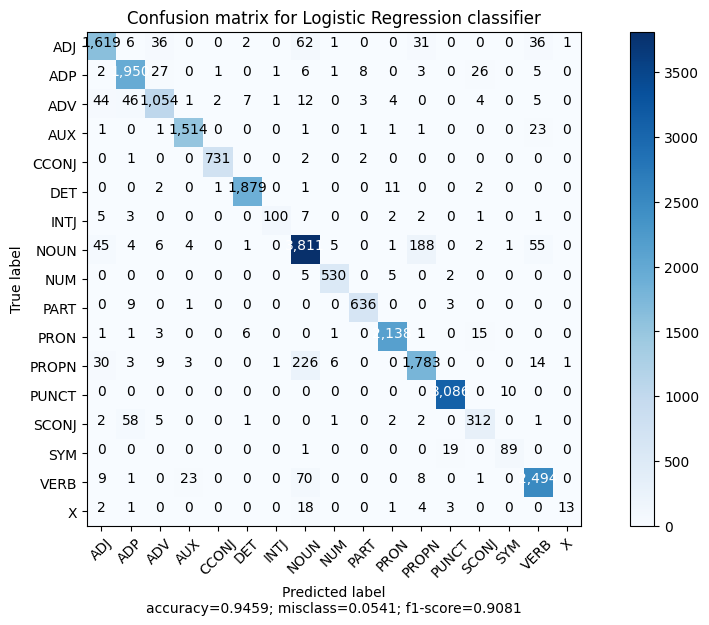

In [80]:
y_pred = clf.predict(X_test)
f1 = f1_score(y_test, y_pred, average='macro')
cnf_matrix = confusion_matrix(y_test, y_pred)
name='Logistic Regression'
plot_confusion_matrix(f1, cnf_matrix, target_names=classes, title='Confusion matrix for '+name+' classifier', normalize=False)

## Tag an Unknown Sentence

Lets try our trained tagger on new sentences.  To tag a sentence given as a string, we must apply the following steps:
* Tokenize the string into a list of tokens
* Turn each token into a features dictionary (using the features used by our model)
* Turn the list of feature dictionaries into vectors (using scikit-learn vectorization method)
* Pass the resulting matrix (one row vector for each token) to the classifier.

In [81]:
# Need to download the nltk model for sentence tokenizer
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\97252\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [82]:
tokens = nltk.word_tokenize('Word embeddings provide a dense representation of words and their relative meanings.')
print(tokens)

['Word', 'embeddings', 'provide', 'a', 'dense', 'representation', 'of', 'words', 'and', 'their', 'relative', 'meanings', '.']


In [83]:
X_features = transform_test_sentence(tokens)

In [84]:
X_features

[[{'nb_terms': 13,
   'word': 'Word',
   'word_lower': 'word',
   'is_first': True,
   'is_last': False,
   'is_capitalized': True,
   'is_all_caps': False,
   'is_all_lower': False,
   'prefix-1': 'W',
   'prefix-2': 'Wo',
   'prefix-3': 'Wor',
   'suffix-1': 'd',
   'suffix-2': 'rd',
   'suffix-3': 'ord',
   'i-1_prefix-3': '',
   'i-1_suffix-3': '',
   'i+1_prefix-3': 'emb',
   'i+1_suffix-3': 'ngs',
   'prev_word': '',
   'next_word': 'embeddings',
   'has_hyphen': False,
   'is_numeric': False,
   'capitals_inside': False}],
 [{'nb_terms': 13,
   'word': 'embeddings',
   'word_lower': 'embeddings',
   'is_first': False,
   'is_last': False,
   'is_capitalized': False,
   'is_all_caps': False,
   'is_all_lower': True,
   'prefix-1': 'e',
   'prefix-2': 'em',
   'prefix-3': 'emb',
   'suffix-1': 's',
   'suffix-2': 'gs',
   'suffix-3': 'ngs',
   'i-1_prefix-3': 'Wor',
   'i-1_suffix-3': 'ord',
   'i+1_prefix-3': 'pro',
   'i+1_suffix-3': 'ide',
   'prev_word': 'word',
   'next_word'

In [85]:
X_vectorized = vec.transform([x[0] for x in X_features])

In [86]:
# The vectorized sentence is a sparse matrix with one row for each token and columns for the vectorized features
# For example, if the vocabulary has 1000 unique words, the vectorized sentence will have 1000 columns for each word feature.
# This is a very sparse matrix, where most of the values are zero.
X_vectorized.shape

(13, 98724)

In [87]:
pred = clf.predict(X_vectorized)

In [88]:
# np.str_ is a subclass of str that is used to represent string arrays in NumPy.
print('Here is what our LR tagger predicts for the test sentence:\n',list(zip(tokens, pred)))

Here is what our LR tagger predicts for the test sentence:
 [('Word', np.str_('PROPN')), ('embeddings', np.str_('NOUN')), ('provide', np.str_('VERB')), ('a', np.str_('DET')), ('dense', np.str_('ADJ')), ('representation', np.str_('NOUN')), ('of', np.str_('ADP')), ('words', np.str_('NOUN')), ('and', np.str_('CCONJ')), ('their', np.str_('PRON')), ('relative', np.str_('ADJ')), ('meanings', np.str_('NOUN')), ('.', np.str_('PUNCT'))]


Let's turn this process into a prediction function from a sentence encoded as a single string to a list of pairs (token, predicted_tag):

In [89]:
def predict_sentence(sentence):
   tokens = nltk.word_tokenize(sentence)
   X_features = transform_test_sentence(tokens)
   X_vectorized = vec.transform([x[0] for x in X_features])
   pred = clf.predict(X_vectorized)
   return list(zip(tokens, pred))

In [90]:
predict_sentence("Let me join the chorus of annoyance over Google's new toolbar , which, as noted in the linked article, commits just about every sin an online marketer could commit, and makes up a few new ones besides.")

[('Let', np.str_('VERB')),
 ('me', np.str_('PRON')),
 ('join', np.str_('VERB')),
 ('the', np.str_('DET')),
 ('chorus', np.str_('NOUN')),
 ('of', np.str_('ADP')),
 ('annoyance', np.str_('NOUN')),
 ('over', np.str_('ADP')),
 ('Google', np.str_('PROPN')),
 ("'s", np.str_('PART')),
 ('new', np.str_('ADJ')),
 ('toolbar', np.str_('NOUN')),
 (',', np.str_('PUNCT')),
 ('which', np.str_('PRON')),
 (',', np.str_('PUNCT')),
 ('as', np.str_('SCONJ')),
 ('noted', np.str_('VERB')),
 ('in', np.str_('ADP')),
 ('the', np.str_('DET')),
 ('linked', np.str_('VERB')),
 ('article', np.str_('NOUN')),
 (',', np.str_('PUNCT')),
 ('commits', np.str_('NOUN')),
 ('just', np.str_('ADV')),
 ('about', np.str_('ADV')),
 ('every', np.str_('DET')),
 ('sin', np.str_('VERB')),
 ('an', np.str_('DET')),
 ('online', np.str_('ADJ')),
 ('marketer', np.str_('NOUN')),
 ('could', np.str_('AUX')),
 ('commit', np.str_('VERB')),
 (',', np.str_('PUNCT')),
 ('and', np.str_('CCONJ')),
 ('makes', np.str_('VERB')),
 ('up', np.str_('ADP'

# Collect Hard Sentences

Hard sentences are sentences that contain multiple wrongly predicted tags given our classifier.

Write code to collect hard sentences given a classifier clf.

In [91]:
def errors_in_sentence_prediction(clf, tagged_sentence):
    """Given a tagged sentence from the dataset, return the number of errors and the predicted tags."""
    errors = 0
    tokens = [word for word, _ in tagged_sentence] 
    true_tags = [true_tag for _, true_tag in tagged_sentence] 

    X_features = transform_test_sentence(tokens)
    X_vectorized = vec.transform([x[0] for x in X_features])
    pred = clf.predict(X_vectorized)

    for i in range(len(tokens)):
        if true_tags[i] != pred[i]:
            errors += 1

    return errors, pred

In [92]:
hard_sentences = []
for s in test_sentences:
    errors, pred = errors_in_sentence_prediction(clf, s)
    if errors > 0:
        hard_sentences.append((s, errors, pred))
print(f'Number of sentences with errors: {len(hard_sentences)} out of {len(test_sentences)}')

Number of sentences with errors: 794 out of 2077


Draw a histogram showing how the sentences in the test dataset are distributed in terms of prediction errors per sentence.

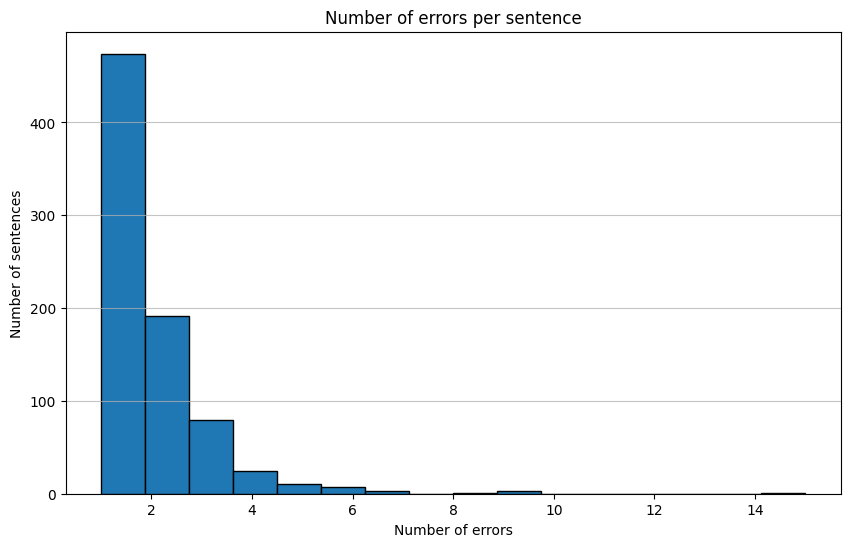

In [93]:
# Draw a histogram of the number of errors per sentence
plt.figure(figsize=(10, 6))
plt.hist([x[1] for x in hard_sentences], bins=16, edgecolor='black')
plt.title('Number of errors per sentence')
plt.xlabel('Number of errors')
plt.ylabel('Number of sentences')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [94]:
# Show prediction errors for sentences with more than 5 errors.
for s in hard_sentences:
    if s[1] > 5:
        print(" ".join(untag(s[0])))
        print('Number of errors:', s[1])
        for i in range(len(s[0])):
            if s[0][i][1] != s[2][i]:
                print(f'{s[0][i][0]:<20}  C: {s[0][i][1]:<12}  P: {s[2][i]:<12} **** Error')
            else:
                print(f'{s[0][i][0]:<23}  {s[0][i][1]:<12}')
        print(40*'=')


Stay with me now : John Paul STEVENS delivered the opinion of the Court with respect to Parts I through IV , VI through VI - D - iii , VI - D - v , and VII , in which KENNEDY , SOUTER , GINSBURG , and BREYER joined , and an opinion with respect to Parts V and VI - D - iv , in which SOUTER , GINSBURG , and BREYER joined .
Number of errors: 8
Stay                     VERB        
with                     ADP         
me                       PRON        
now                      ADV         
:                        PUNCT       
John                     PROPN       
Paul                     PROPN       
STEVENS               C: PROPN         P: NOUN         **** Error
delivered                VERB        
the                      DET         
opinion                  NOUN        
of                       ADP         
the                      DET         
Court                    NOUN        
with                     ADP         
respect                  NOUN        
to                   

## Error Analysis

1. Identify tokens that are misclassified more than 10 times in the test set. Print the sentences where the errors are predicted (about 100 sentences).
2. Provide a possible reason why these errors are made by the tagger based on your understanding of the knowledge needed to correctly tag these tokens.
3. Based on this error analysis, invent five sentences that are badly tagged. Explain what is your method to create these hard examples.


In [95]:
tokens = collections.defaultdict(list)
sen_ids = [] 
for i, s in enumerate(hard_sentences):
    words = [word for word, _ in hard_sentences[i][0]]
    full_s = ' '.join(words)
    sen_ids.append(full_s)
    for j in range(len(s[0])):
        if s[0][j][1] != s[2][j]:
            tokens[s[0][j][0]].append(i)

sentences = set()
print("Tokens with more than 10 errors:")
for token, lst in tokens.items():
    if len(lst) > 10:
        print(token)
        for index in lst:
            sentences.add(sen_ids[index])

print("Total amount of sentences:", len(sentences))

print("Sentences where the errors are predicted:\n")
for s in sentences:
    print(s)

Tokens with more than 10 errors:
out
on
as
to
/
that
for
up
like
in
Total amount of sentences: 162
Sentences where the errors are predicted:

Well , they have a variety of sports that they play like basketball , soccer , etc .
Opinions , conclusions and other information in this message that do not relate to the official business of my firm shall be understood as neither given nor endorsed by it .
This acceptance of blatantly terrorist groups as legitimate freedom movements is a cancerous tumor on the United Nations and the media .
Obviously , he should have been arrested and jailed - imagine making a statue or painting on the same subject as another artist - clearly insulting and disrespecting - wasted time that could have been used making a statue with clothes on .
Restaurant on top was renovated , food was decent , price was way to high for Duluth for quality , new decor seems tacky
Also very friendly and the stylists are not in the " been there / done that " mood !
Have you seen th

2


In [1]:
# --- Imports ---
import os
from openai import OpenAI
from pydantic import BaseModel, Field
from enum import Enum
from typing import List, Optional
import time

# 
model = 'grok-3-mini'

In [2]:
# --- Define the Universal Dependencies POS Tagset (17 core tags) as an enum ---
class UDPosTag(str, Enum):
    ADJ = "ADJ"     # adjective
    ADP = "ADP"     # adposition
    ADV = "ADV"     # adverb
    AUX = "AUX"     # auxiliary verb
    CCONJ = "CCONJ" # coordinating conjunction
    DET = "DET"     # determiner
    INTJ = "INTJ"   # interjection
    NOUN = "NOUN"   # noun
    NUM = "NUM"     # numeral
    PART = "PART"   # particle
    PRON = "PRON"   # pronoun
    PROPN = "PROPN" # proper noun
    PUNCT = "PUNCT" # punctuation
    SCONJ = "SCONJ" # subordinating conjunction
    SYM = "SYM"     # symbol
    VERB = "VERB"   # verb
    X = "X"         # other / unknown


In [ ]:
# TODO Define more Pydantic models for structured output
class TokenPOS(BaseModel):
    text: str = Field(description="The token text")
    pos_tag: UDPosTag = Field(description="The Universal Dependencies POS tag")

class SentencePOS(BaseModel):
    tokens: List[TokenPOS] = Field(description="List of tokens with their POS tags")

class TaggedSentences(BaseModel):
    """Represents a list of sentences with their tagged tokens."""
    sentences: List[SentencePOS] = Field(description="A list of sentences, each containing tagged tokens.")

# --- Configure the Grok API ---
# Get a key https://console.x.ai/team 
# Use os.environ.get for production environments.
# For Colab/AI Studio, you might use userdata.get
# Example:
# from google.colab import userdata
# GROK_API_KEY = userdata.get('GROK_API_KEY')
# genai.configure(api_key=GROK_API_KEY)

# Make sure to replace "YOUR_API_KEY" with your actual key if running locally
# and not using environment variables or userdata.
try:
    # Attempt to get API key from environment variable
    def load_env_from_ini(filename):
        with open(filename) as f:
            for line in f:
                line = line.strip()
                if not line or line.startswith('#'):
                    continue
                key, value = line.split('=', 1)
                os.environ[key.strip()] = value.strip()

    # Load the API key
    load_env_from_ini("grok_key.ini")
    api_key = os.environ.get("GROK_API_KEY")
    if not api_key:
        # Fallback or specific instruction for local setup
        # Replace with your actual key if needed, but environment variables are safer
        api_key = "YOUR_API_KEY"
        if api_key == "YOUR_API_KEY":
           print("⚠️ Warning: API key not found in environment variables. Using placeholder.")
           print("   Please set the GROK_API_KEY environment variable or replace 'YOUR_API_KEY' in the code.")

    client = OpenAI(
        api_key=api_key,
        base_url="https://api.x.ai/v1",
    )

except Exception as e:
    print(f"Error configuring API: {e}")
    print("Please ensure you have a valid API key set.")
    # Depending on the environment, you might want to exit here
    # import sys
    # sys.exit(1)



⚠️ Warning: API key not found in environment variables. Using placeholder.
   Please set the GROK_API_KEY environment variable or replace 'YOUR_API_KEY' in the code.


In [ ]:
def tag_sentences_ud(text_to_tag: str) -> Optional[TaggedSentences]:
    """
    Performs POS tagging on the input list of sentences using the Grok API and
    returns the result structured according to the TaggedSentences Pydantic model.

    Args:
        text_to_tag: The sentence or text to be tagged.

    Returns:
        A SentencePOS object containing the tagged tokens, or None if an error occurs.
    """
    # Construct the prompt
    prompt = f"""You are a part-of-speech tagger using the Universal Dependencies (UD) tagset. Your task is to analyze the given text, split it into tokens according to UD guidelines, and assign the correct POS tag to each token.

        The UD POS tagset consists of 17 universal tags:
        1. ADJ: adjective (e.g., big, old, green)
        2. ADP: adposition (e.g., in, to, during)
        3. ADV: adverb (e.g., very, well, exactly)
        4. AUX: auxiliary verb (e.g., is, has, must)
        5. CCONJ: coordinating conjunction (e.g., and, or, but)
        6. DET: determiner (e.g., a, an, the)
        7. INTJ: interjection (e.g., oh, wow, ah)
        8. NOUN: noun (e.g., car, girl, tree)
        9. NUM: numeral (e.g., 2, two, second)
        10. PART: particle (e.g., 's in "John's", to in "going to")
        11. PRON: pronoun (e.g., I, you, she)
        12. PROPN: proper noun (e.g., John, London, IBM)
        13. PUNCT: punctuation (e.g., ., !, ?)
        14. SCONJ: subordinating conjunction (e.g., if, while, that)
        15. SYM: symbol (e.g., $, %, §)
        16. VERB: verb (e.g., run, eat, play)
        17. X: other (for words that cannot be assigned a category)

        Follow these UD segmentation guidelines:
        - Split contracted forms (e.g., "don't" → "do" [AUX] + "n't" [PART])
        - Split hyphenated compounds into separate tokens (e.g., "search-engine" → "search" [NOUN] + "-" [PUNCT] + "engine" [NOUN])
        - Treat multiword tokens as separate tokens (e.g., "because of" → "because" [SCONJ] + "of" [ADP])
        - Separate punctuation from words (e.g., "(hello)" → "(" [PUNCT] + "hello" [NOUN] + ")" [PUNCT])

        Please analyze the following text and tag each token:
        {text_to_tag}

        Return your analysis in a structured format where each sentence is split into tokens, and each token has its corresponding POS tag.
    """

    completion = client.beta.chat.completions.parse(
        model="grok-3",
        messages=[
            {"role": "system", "content": prompt},
            {"role": "user", "content": text_to_tag},
        ],
        response_format=TaggedSentences,
    )
    # print(completion)
    res = completion.choices[0].message.parsed
    return res


In [127]:
def batch_tag_sentences_ud(sentences: List[str], batch_size: int = 5, rate_limit_delay: float = 4.0) -> List[TaggedSentences]:
    """
    Performs POS tagging on a list of sentences in batches to respect API rate limits.
    Args:
    sentences: List of sentences to be tagged
    batch_size: Number of sentences to include in each API call
    rate_limit_delay: Delay in seconds between API calls to respect rate limits
    Returns:
    List of TaggedSentences objects
    """
    results = []
    # Process sentences in batches
    for i in range(0, len(sentences), batch_size):
        batch = sentences[i:i+batch_size]
        # Join the batch into a single text with sentence separators
        batch_text = "\n\n".join(batch)
        print(f"Processing batch {i//batch_size + 1}/{(len(sentences) + batch_size - 1)//batch_size}...")
        # Process the batch
        batch_result = tag_sentences_ud(batch_text)
        if batch_result:
            results.append(batch_result)
        # Respect rate limits by adding a delay between API calls
        if i + batch_size < len(sentences):
            print(f"Waiting {rate_limit_delay} seconds to respect API rate limits...")
        time.sleep(rate_limit_delay)
    return results


In [ ]:
# --- Example Usage ---
if __name__ == "__main__":
    # example_text = "The quick brown fox jumps over the lazy dog."
    example_text = """
    What if Google expanded on its search-engine (and now e-mail) wares into a full-fledged operating system?
    Google Search is a web search engine developed by Google LLC.
    It does n't change the company 's intrinsic worth , and as the article notes , the company might be added to a major index once the shares get more liquid .
    I 've been looking at the bose sound dock 10 i ve currently got a jvc mini hifi system , i was wondering what would be a good set of speakers .
    which is the best burger chain in the chicago metro area like for example burger king portillo s white castle which one do you like the best ?
    """
    # example_text = "החתול המהיר קופץ מעל הכלב העצלן." # Example in Hebrew

    print(f"\nTagging text: \"{example_text}\"")

    tagged_result = tag_sentences_ud(example_text)

    if tagged_result:
        print("\n--- Tagging Results ---")
        for s in tagged_result.sentences:
            # TODO: Retrieve tokens and tags from each sentence:
            for token in s.tokens:
                tag = token.pos_tag
                token = token.text
                # Handle potential None for pos_tag if model couldn't assign one
                ctag = tag if tag is not None else "UNKNOWN"
                print(f"Token: {token:<15} {str(ctag)}")
                print("----------------------")
    else:
        print("\nFailed to get POS tagging results.")


Tagging text: "What if Google expanded on its search-engine (and now e-mail) wares into a full-fledged operating system?"
{
  "sentences": [
    {
      "tokens": [
        {
          "text": "What",
          "pos_tag": "SCONJ"
        },
        {
          "text": "if",
          "pos_tag": "SCONJ"
        },
        {
          "text": "Google",
          "pos_tag": "PROPN"
        },
        {
          "text": "expanded",
          "pos_tag": "VERB"
        },
        {
          "text": "on",
          "pos_tag": "ADP"
        },
        {
          "text": "its",
          "pos_tag": "PRON"
        },
        {
          "text": "search",
          "pos_tag": "NOUN"
        },
        {
          "text": "-",
          "pos_tag": "PUNCT"
        },
        {
          "text": "engine",
          "pos_tag": "NOUN"
        },
        {
          "text": "(",
          "pos_tag": "PUNCT"
        },
        {
          "text": "and",
          "pos_tag": "CCONJ"
        },
      

In [133]:
import time  # for adding delays to avoid overloading the model

lr_hard_sentences = [s[0] for s in hard_sentences if 1 <= s[1] <= 3]
llm_hard_sentences = []
results_llm = batch_tag_sentences_ud(test_original, batch_size=5, rate_limit_delay=6.0)
llm_pred = [[token.pos_tag for token in sentence.tokens] for sentence in results_llm.sentences]

for s in test_sentences:
    tokens = [word for word, _ in s]
    true_tags = [true_tag for _, true_tag in s]
    for j in range(len(tokens)):
        if true_tags[j] != llm_pred[i][j]:
            llm_hard_sentences.append((s, errors, llm_pred[i][j]))

print(f'Number of sentences with errors: {len(llm_hard_sentences)} out of {len(test_sentences)}')
print(f'Number of sentences with errors: {len(lr_hard_sentences)} out of {len(test_sentences)}')

Processing batch 1/416...
{
  "sentences": [
    {
      "tokens": [
        {
          "text": "What",
          "pos_tag": "DET"
        },
        {
          "text": "if",
          "pos_tag": "SCONJ"
        },
        {
          "text": "Google",
          "pos_tag": "PROPN"
        },
        {
          "text": "Morphed",
          "pos_tag": "VERB"
        },
        {
          "text": "Into",
          "pos_tag": "ADP"
        },
        {
          "text": "GoogleOS",
          "pos_tag": "PROPN"
        },
        {
          "text": "?",
          "pos_tag": "PUNCT"
        }
      ]
    },
    {
      "tokens": [
        {
          "text": "What",
          "pos_tag": "DET"
        },
        {
          "text": "if",
          "pos_tag": "SCONJ"
        },
        {
          "text": "Google",
          "pos_tag": "PROPN"
        },
        {
          "text": "expanded",
          "pos_tag": "VERB"
        },
        {
          "text": "on",
          "pos_tag": "A

ServerError: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'The model is overloaded. Please try again later.', 'status': 'UNAVAILABLE'}}

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))  
    
# Plot the histogram for LR
ax[0].hist([x[1] for x in lr_hard_sentences], bins=4, edgecolor='black', rwidth=0.8)
ax[0].set_title("LR Tagger Error Histogram")
ax[0].set_xlabel("Number of Errors")
ax[0].set_ylabel("Frequency")

# Plot the histogram for LLM
ax[1].hist([x[1] for x in llm_hard_sentences], bins=4, edgecolor='black', rwidth=0.8)
ax[1].set_title("LLM Tagger Error Histogram")
ax[1].set_xlabel("Number of Errors")
ax[1].set_ylabel("Frequency")

# Display the plots
plt.tight_layout()
plt.show()

In [ ]:
fixes = 0

for i in hard_sent_indices:
    g = gold_tags[i]
    lr = lr_tags[i]
    llm = llm_tags[i]
    
    for gt, lrp, llmp in zip(g, lr, llm):
        if gt != lrp and gt == llmp:
            fixes += 1  # LLM fixed LR error

print(f"✅ Fixes: {fixes}")

#############################################################
regressions = 0

for i in hard_sent_indices:
    g = gold_tags[i]
    lr = lr_tags[i]
    llm = llm_tags[i]
    
    for gt, lrp, llmp in zip(g, lr, llm):
        if gt == lrp and gt != llmp:
            regressions += 1  # LLM introduced a new error

print(f"❌ Regressions: {regressions}")


In [ ]:
print(classification_report(y_test, clf.predict(X_test), digits=4))

In [ ]:
import collections
k=0
i2w = id2word(test_sentences)
error_counter = collections.Counter()
for i in range(X_test.shape[0]):
    correct_tag_id = y_test
    if y_pred[i]!=y_test[i]:
        k += 1
        word = i2w[i]
        error_counter[word] += 1
print('Accuracy: {0:.4f}'.format((len(i2w)-k)/len(i2w)))
print('Total errors/Total words: {}/{}\n'.format(k,len(i2w)))
print('Most common errors:',error_counter.most_common(20))

In [ ]:
y_pred = clf.predict(X_test)
f1 = f1_score(y_test, y_pred, average='macro')
cnf_matrix = confusion_matrix(y_test, y_pred)
name='Logistic Regression'
plot_confusion_matrix(f1, cnf_matrix, target_names=classes, title='Confusion matrix for '+name+' classifier', normalize=False)